In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(suppress=True, precision=4)

Text(0.5, 0, 'y, метры')

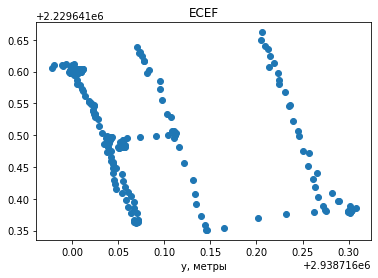

In [3]:
path = "HI2 ublox.csv"
dtype = {"X" : np.float64, "Y" : np.float64, "Z" : np.float64, 
        "Lat" : np.float64, "Lon" : np.float64}
df = pd.read_csv(path, dtype=dtype)
plt.scatter(df["X"], df["Y"]) # в ECEF
plt.title("ECEF")
plt.xlabel("x, метры")
plt.xlabel("y, метры")

In [4]:
df.columns

Index(['GPS time', 'X', 'Y', 'Z', 'Lat', 'Lon'], dtype='object')

In [5]:
r0 = np.sqrt(df.at[0, "X"]**2 + df.at[0, "Y"]**2 + df.at[0, "Z"]**2)
lat0 = df.at[0, "Lat"]
lon0 = df.at[0, "Lon"]
df["r"] = df.apply(lambda x: np.array([[x["X"], x["Y"], x["Z"], 1]]).T, axis=1)
df["r"]


0      [[2938716.0], [2229641.598], [5186002.929], [1...
1      [[2938716.001], [2229641.6], [5186002.93], [1.0]]
2        [[2938716.0], [2229641.6], [5186002.93], [1.0]]
3      [[2938715.999], [2229641.599], [5186002.929], ...
4      [[2938715.998], [2229641.6], [5186002.928], [1...
                             ...                        
286    [[2938716.3010000004], [2229641.38], [5186002....
287    [[2938716.2989999996], [2229641.38], [5186002....
288    [[2938716.3], [2229641.38], [5186002.758], [1.0]]
289    [[2938716.3], [2229641.38], [5186002.758], [1.0]]
290    [[2938716.2989999996], [2229641.379], [5186002...
Name: r, Length: 291, dtype: object

In [6]:
def rot_NSSK2ECEF(_lambda, varphi, psi): # TODO rename to rot_NSSK2ECI
    """
    # TODO от 17 08 2021 - чтото матрица поворота выглядит косячно... не работает должным образом
    Матрица поворота, которая поворачивает вектор из НССК в ECEF
    :param _lambda: долгота, положительный отсчет в южное полушарие (против часовой стрелки от гринвича)
    :param varphi: широта, положительный отсчет в северное полушарие
    :param psi: азимут, положительный отсчет по часовой стрелке от направления на север
    :return:
    """
    return np.array([[-np.sin(_lambda) * np.sin(psi) - np.sin(varphi) * np.cos(_lambda) * np.cos(psi),
                      np.cos(_lambda) * np.cos(varphi),
                      -np.sin(_lambda) * np.cos(psi) + np.sin(psi) * np.sin(varphi) * np.cos(_lambda)],
                     [-np.sin(_lambda) * np.sin(varphi) * np.cos(psi) + np.sin(psi) * np.cos(_lambda),
                      np.sin(_lambda) * np.cos(varphi), np.sin(
                         _lambda) * np.sin(psi) * np.sin(varphi) + np.cos(_lambda) * np.cos(psi)],
                     [np.cos(psi) * np.cos(varphi), np.sin(varphi),
                      -np.sin(psi) * np.cos(varphi)]])

def T_NSSK2ECEF(_lambda, varphi, psi, r):
    """
    Матрица перехода из НССК в ECEF
    :param _lambda: долгота, положительный отсчет в южное полушарие (против часовой стрелки от гринвича)
    :param varphi: широта, положительный отсчет в северное полушарие
    :param psi: азимут, положительный отсчет по часовой стрелке от направления на север
    :param r: радиус до origin НССК в ECEF
    :return:
    """
    tr = rz(_lambda) @ ry(-varphi) @ np.array([r, 0., 0.])[np.newaxis].T
    rot = rot_NSSK2ECEF(_lambda, varphi, psi)
    T = np.vstack((np.hstack((rot, tr)), [0, 0, 0, 1]))
    return T

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
Re = 6378e3
Rz = Re
%matplotlib notebook

# @title
def plot_3Dpose(frames=[], poses=[], show_t=True, show_coord=True, show_pose=True, t_names=['$\mathbf{t}$']):
    """Plotting poses in frames

    Args:
        frames (list): frames to plot in addition to original frame.
        poses (list): poses to plot in the original frame.

        show_t (bool): depict t-vector name
        show_coord (bool): depict pose coordinates

    Returns:
        None.
    """
    def get_xyzuvctt(T):
        t = T[:3, 3:4].flatten(); 
        t_ = t / (np.linalg.norm(t) + 1e-5) 
        R = T[:3, :3]
        (x, y, z), (u, v, c) = np.repeat(t_.reshape(3, 1), 3, axis=1), R
        return x, y, z, u, v, c, t, t_

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    lngth = Rz

    # fig appearance
    ax.view_init(elev=22, azim=32)
    # ax.set_aspect('equal')
    ax.view_init(elev=22, azim=20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.axis('off');  # ax.axis('equal')

    # origin and coordinate axes (coordinate frame)
    xl = 'x';
    yl = 'y';
    zl = 'z';
    ol = 'O'
    x, y, z, u, v, c, t, t_ = get_xyzuvctt(np.eye(4))
    
    ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
    ax.quiver(x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
    ax.text(0, -0.5, -0.1, ol);
    ax.text(lngth * 1.2, 0, 0, xl);
    ax.text(0, lngth * 1.2, 0, yl);
    ax.text(0, 0, lngth * 1.2, zl)
    # aid to have initial minimum dimensions of plot
    ax.scatter(4, 4, 4, alpha=0)

    for frame in frames:
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(frame)
        ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
        ax.quiver(
            x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
        xl += '\'';
        yl += '\'';
        zl += '\'';
        ol += '\''
        ax.text(t_[0], t_[1] - 0.5, t_[2] - 0.1, ol);
        frame = frame @ np.diag([lngth * 1.2, lngth * 1.2, lngth * 1.2, 1])
        ax.text(frame[:3, :3][0][0] + t_[0], frame[:3, :3][1][0] + t_[1], frame[:3, :3][2][0] + t_[2], xl);
        ax.text(frame[:3, :3][0][1] + t_[0], frame[:3, :3][1][1] + t_[1], frame[:3, :3][2][1] + t_[2], yl);
        ax.text(frame[:3, :3][0][2] + t_[0], frame[:3, :3][1][2] + t_[1], frame[:3, :3][2][2] + t_[2], zl);

    for i, pose in enumerate(poses):
        # given frame
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(pose)
        if show_pose:
            x *= lngth
            y *= lngth
            z *= lngth
            u *= lngth/3
            v*= lngth/3
            c*= lngth/3
            ax.quiver(x, y, z, u, v, c, arrow_length_ratio=0, color=['r', 'g', 'b'], linestyle='-', linewidth=2)
        # t-vector
        alr = 0.1
        ax.quiver(0, 0, 0, t_[0]*lngth, t_[1]*lngth, t_[2]*lngth, color='k', arrow_length_ratio=alr, linewidth=1)
        for frame in frames:
            _, _, _, _, _, _, _, tf_ = get_xyzuvctt(frame)
            tf2_ = t_ - tf_
            ax.quiver(tf_[0], tf_[1], tf_[2], tf2_[0], tf2_[1], tf2_[2],
                      color='k', arrow_length_ratio=alr, linewidth=2)
        # t-vector name
        # if show_t:
        # tf2_ = t_-tf_/2
        #    ax.text(t_[0]/2, t_[1]/2, t_[2]/2+0.4, t_names[i], fontsize=20)
        # coordinates
        if show_coord:
            t0 = "{0:.2f}".format(t[0])
            t1 = "{0:.2f}".format(t[1])
            t2 = "{0:.2f}".format(t[2])
            ax.text(t_[0], t_[1], t_[2], '(' + t0 + ',' + t1 + ',' + t2 + ')')
            
    return ax 


def rx(alpha):
    """
    Повотор вокруг оси Х
    :param alpha: угол в радианах
    :return:
    """
    rx = [[1, 0, 0],
          [0, np.cos(alpha), -np.sin(alpha)],
          [0, np.sin(alpha), np.cos(alpha)]]
    return np.array(rx)


def ry(alpha):
    """
    Повотор вокруг оси Y
    :param alpha: угол в радианах
    :return:
    """
    ry = [[np.cos(alpha), 0, np.sin(alpha)],
          [0, 1, 0],
          [-np.sin(alpha), 0, np.cos(alpha)]]
    return np.array(ry)

def rz(alpha):
    """
    Повотор вокруг оси Z
    :param alpha: угол в радианах
    :return:
    """
    rz = [[np.cos(alpha), -np.sin(alpha), 0],
          [np.sin(alpha), np.cos(alpha), 0],
          [0, 0, 1]]
    return np.array(rz)

def NT(_lambda, zeta, psi):
    return np.array([[np.sin(_lambda)*np.sin(psi) + np.sin(zeta)*np.cos(_lambda)*np.cos(psi), 
                    np.cos(_lambda)*np.cos(zeta),
                     -np.sin(_lambda)*np.cos(psi) + np.sin(psi)*np.sin(zeta)*np.cos(_lambda)], 

                     [np.sin(_lambda)*np.sin(zeta)*np.cos(psi) - np.sin(psi)*np.cos(_lambda), 
                    np.sin(_lambda)*np.cos(zeta), 
                    np.sin(_lambda)*np.sin(psi)*np.sin(zeta) + np.cos(_lambda)*np.cos(psi)], 

                    [np.cos(psi)*np.cos(zeta), 
                    -np.sin(zeta), 
                    np.sin(psi)*np.cos(zeta)]])


Азимут 7.993314292321988e-17


<IPython.core.display.Javascript object>


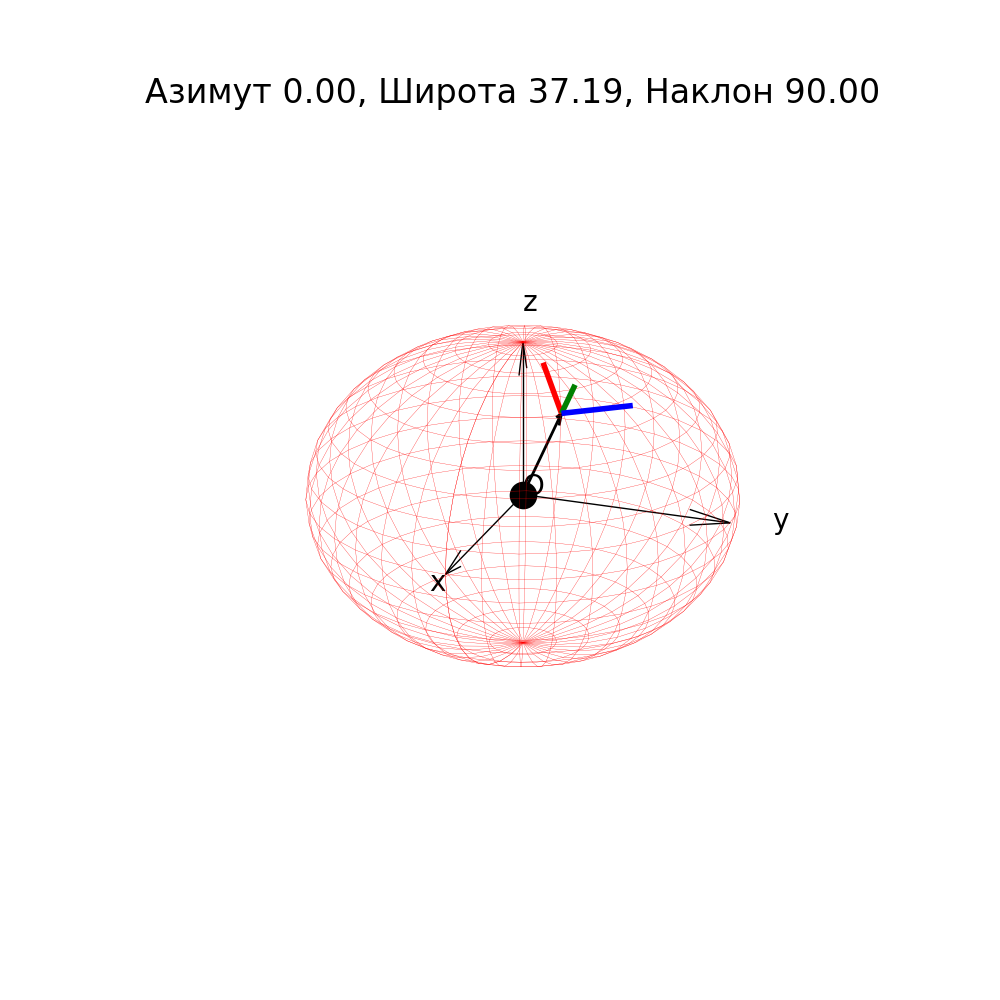

Text(0.5, 0.92, 'Азимут 0.00, Широта 37.19, Наклон 90.00')

In [8]:
lat = np.deg2rad(40) # широта
i = np.deg2rad(90) # inclination
az = np.arcsin(np.cos(i)/np.cos(lat))
print("Азимут", az)


psi = np.deg2rad(0)
_lambda = np.deg2rad(lon0)
zeta = np.deg2rad(-lat0)

r = NT(_lambda, zeta, psi) # матриц поворота стартовой СК
# r = rot_NSSK2ECEF(zeta, _lambda, psi)
# а теперь отдельно поворачиваем точку (костылек)
tr = rz(_lambda) @ ry(zeta) @ np.array([r0, 0., 0.])[np.newaxis].T
T1 = np.vstack((np.hstack((r, tr)), [0,0,0,1]))
ax = plot_3Dpose(poses=[T1], show_coord = False)

# скопировал отрисовку сферы
u = np.linspace(0, 2 * np.pi, 39)
v = np.linspace(0, np.pi, 21)

x = Re * np.outer(np.cos(u), np.sin(v))
y = Re * np.outer(np.sin(u), np.sin(v))
z = Re * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color="r", linewidth = 0.1)
# points = propagate_orbit()
# points = r @ points.reshape(-1, 3, 1)
# points = points.reshape(-1, 3)
# ax.plot(points[:,0], points[:,1], points[:,2])
ax.set_title(f"Азимут {np.rad2deg(psi):.2f}, Широта {np.rad2deg(_lambda):.2f}, Наклон {np.rad2deg(i):.2f}" )


<IPython.core.display.Javascript object>


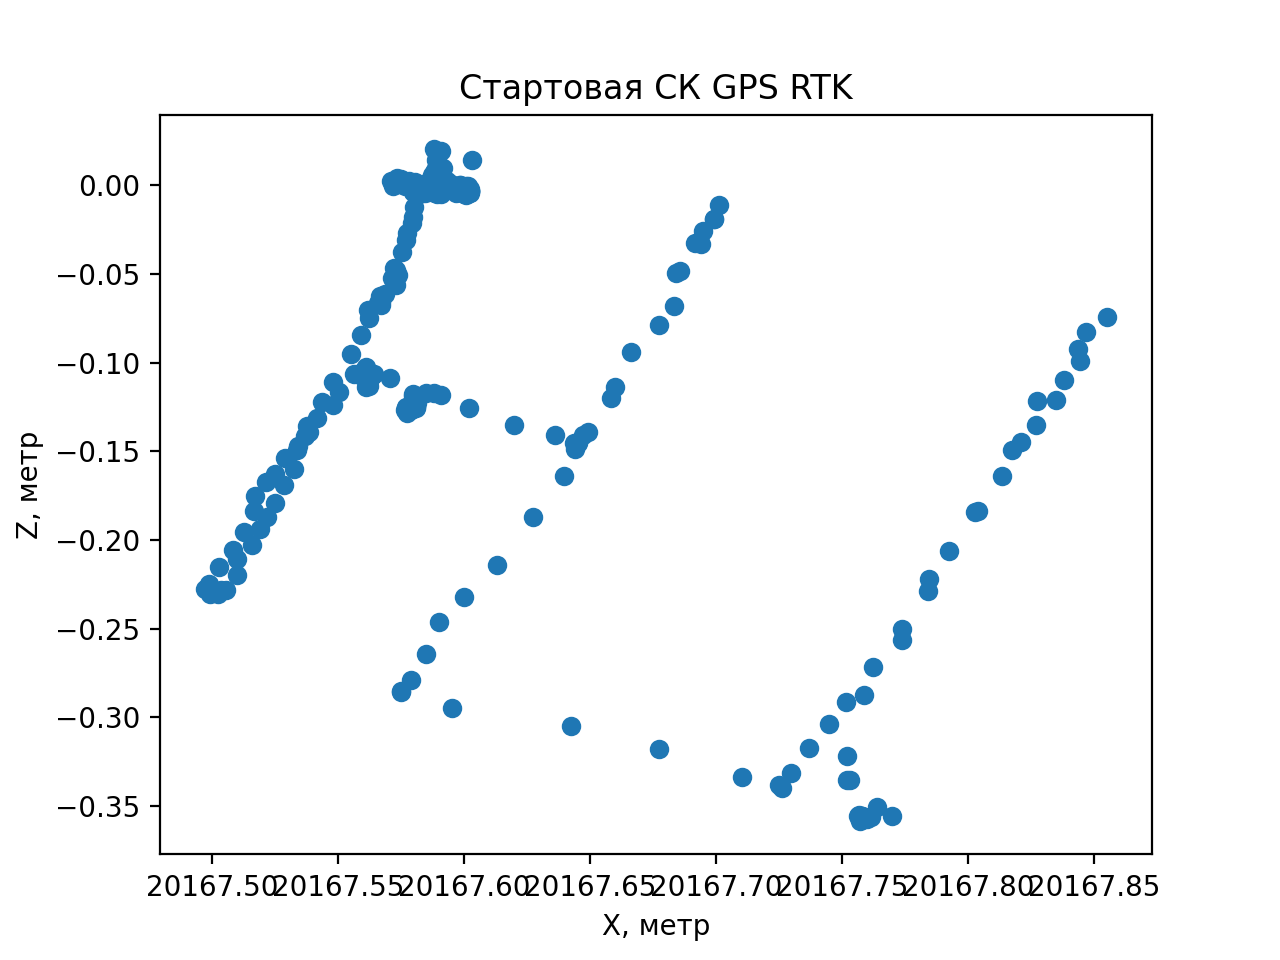

In [11]:
T1 = np.vstack((np.hstack((r, tr)), [0,0,0,1]))
df["r_ssk"] = df.apply(lambda x: (np.linalg.inv(T1) @ x["r"]).T, axis=1)
xyz_ssk = np.vstack(df["r_ssk"]).T

plt.figure()
plt.scatter(-xyz_ssk[0], xyz_ssk[2])
plt.title("Стартовая СК GPS RTK")
plt.xlabel("X, метр")
plt.ylabel("Z, метр")
plt.ticklabel_format(useOffset=False)
plt.show()

In [95]:
xyz_ssk.T

array([[-20167.5684,    -31.9551,      0.0009,      1.    ],
       [-20167.5697,    -31.9566,     -0.0005,      1.    ],
       [-20167.5697,    -31.9566,     -0.0005,      1.    ],
       [-20167.5685,    -31.9563,      0.0001,      1.    ],
       [-20167.5686,    -31.9561,     -0.0013,      1.    ],
       [-20167.5681,    -31.9565,     -0.0021,      1.    ],
       [-20167.5682,    -31.9577,     -0.0029,      1.    ],
       [-20167.5693,    -31.9557,     -0.0019,      1.    ],
       [-20167.5733,    -31.9541,     -0.0014,      1.    ],
       [-20167.5726,    -31.9545,     -0.0008,      1.    ],
       [-20167.576 ,    -31.9534,      0.0004,      1.    ],
       [-20167.5745,    -31.9569,     -0.0022,      1.    ],
       [-20167.5728,    -31.9618,     -0.0027,      1.    ],
       [-20167.5736,    -31.9636,     -0.0049,      1.    ],
       [-20167.5741,    -31.9646,     -0.0035,      1.    ],
       [-20167.5717,    -31.9674,     -0.0033,      1.    ],
       [-20167.5706,    

In [73]:
np.linalg.inv(T1)

array([[      -0.6506,       -0.4937,        0.577 ,       -0.    ],
       [       0.4597,        0.3488,        0.8167, -6364116.2368],
       [      -0.6044,        0.7967,        0.    ,        0.    ],
       [       0.    ,        0.    ,        0.    ,        1.    ]])

In [77]:
r.T @ df.at[0, "r"][:3]

array([[ -20167.5684],
       [6364084.2817],
       [      0.0009]])